# obs

## coast

In [13]:
[xmin,xmax,ymin,ymax]=[330,355,10,35]
[tmin,tmax]=["1993","2022"]

# coast
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm
import glob


file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(
    file_path
)


lon=ds['lon'].sel(lon=slice(xmin, xmax)).values
lat=ds['lat'].sel(lat=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))



sst0=np.squeeze(ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0).values)


    
coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  



## sstu


In [ ]:
file_path = os.path.expandvars('$WORK/data/OISST/daily/oisst_daily_mean_1993_2022.nc')
ds = xr.open_dataset(
    file_path
)
sstd=ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax),time=slice(tmin,tmax)).values

n = 16
ssto = np.empty((sstd.shape[0],len(coast['lat']), n))
lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))


for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    ssto[:, point_idx, :] = sstd[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal and ocean band
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]
lonc=lono[:,8:]
latc=lato[:,8:]
sstu_d=ssto[:,:,8:]-ssto[:,:,0:8]
np.savez(f'sstu_d_{tmin}_{tmax}.npz', sstu_d=sstu_d, ssto=ssto, coast=coast, lonc=lonc, latc=latc, lono=lono, lato=lato, time=time)

## ekman

In [ ]:
import glob

base_dir = os.path.expandvars('$WORK/data/CCMP/daily6h/')
data_dirs = [os.path.join(base_dir, f"{year}") for year in range(int(tmin), int(tmax) + 1)]
file_list = []
for data_dir in data_dirs:
    file_pattern = os.path.join(data_dir, 'CCMP_Wind_Analysis_????????_V03.1_L4.nc')
    file_list.extend(glob.glob(file_pattern))
file_list = sorted(file_list)

ds = xr.open_mfdataset(file_list, combine='by_coords')
u=ds['uwnd'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).groupby("time.dayofyear").mean(dim="time").values
v=ds['vwnd'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).groupby("time.dayofyear").mean(dim="time").values

In [ ]:
# wind ekman transport and pumping


n = 8
uc = np.empty((u.shape[0],len(coast['lat']), n))
vc = np.empty((v.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = u[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = v[:, lat_idx, int(lon_idx-n) : int(lon_idx)]

uc[np.abs(uc) > 100] = np.nan
vc[np.abs(vc) > 100] = np.nan

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
wind_alongshore = uc * u_alongshore + vc * v_alongshore

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, latc, lonc)  # Shape: (100, 8)

# Constants
rhoa = 1.22  # air density (kg/m^3)
cd = 0.0013  # drag coefficient
rho = 1025  # water density (kg/m^3)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

f = 2 * omega * np.sin(latc* np.pi / 180)

# Calculate magnitude of horizontal velocity
windspeed = np.sqrt(uc**2 + vc**2)

# Ekman transport calculation
etransport = -rhoa * cd * windspeed * wind_alongshore / (rho * f * distances)

dy = 111000*(lon[1]-lon[0])  # 1 degree latitude ~ 111 km
epumping = rhoa * cd * windspeed * (np.gradient(vc, dy, axis=2)-np.gradient(uc, dy, axis=1)) / (rho * f)

np.savez(f'ekman_d_{tmin}_{tmax}.npz', windspeed=windspeed, etransport=etransport, epumping=epumping)


## heat flux

In [8]:
# hfxc
import glob

data_dir = os.path.expandvars('$WORK/data/Tropflux/daily')
file_pattern = os.path.join(data_dir, 'netflux_tropflux_1d_????.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
netflux=ds['netflux'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).groupby("time.dayofyear").mean(dim="time")
netflux=netflux.interpolate_na(dim="longitude", method="nearest")
netflux=netflux.interpolate_na(dim="latitude", method="nearest")
netflux=netflux.bfill(dim="longitude")
netflux=netflux.bfill(dim="latitude")
lat_xr = xr.DataArray(lat, dims="latitude")
lon_xr = xr.DataArray(lon, dims="longitude")
hflx = netflux.interp(latitude=lat_xr, longitude=lon_xr).values

n = 16
hflxo = np.empty((hflx.shape[0],len(coast['lat']), n))
lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    hflxo[:, point_idx, :] = hflx[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal and ocean band
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]
lonc=lono[:,8:]
latc=lato[:,8:]
hflxu=hflxo[:,:,8:]-hflxo[:,:,0:8]
np.savez(f'hflxu_d_{tmin}_2018.npz', hflxo=hflxo, hflxu=hflxu, coast=coast, lonc=lonc, latc=latc, lono=lono, lato=lato, time=time)

In [3]:
# shortwave
import glob

data_dir = os.path.expandvars('$WORK/data/Tropflux/daily')
file_pattern = os.path.join(data_dir, 'swr_tropflux_1d_????.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
netflux=ds['swr'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).groupby("time.dayofyear").mean(dim="time")
netflux=netflux.interpolate_na(dim="longitude", method="nearest")
netflux=netflux.interpolate_na(dim="latitude", method="nearest")
netflux=netflux.bfill(dim="longitude")
netflux=netflux.bfill(dim="latitude")
lat_xr = xr.DataArray(lat, dims="latitude")
lon_xr = xr.DataArray(lon, dims="longitude")
hflx = netflux.interp(latitude=lat_xr, longitude=lon_xr).values

n = 16
hflxo = np.empty((hflx.shape[0],len(coast['lat']), n))
lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    hflxo[:, point_idx, :] = hflx[:, lat_idx, int(lon_idx-n) : int(lon_idx)]      # costal and ocean band
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]
lonc=lono[:,8:]
latc=lato[:,8:]
hflxu=hflxo[:,:,8:]-hflxo[:,:,0:8]
np.savez(f'swr_d_{tmin}_2018.npz', swro=hflxo, swru=hflxu, coast=coast, lonc=lonc, latc=latc, lono=lono, lato=lato, time=time)

## w estimate

In [3]:
# estimate ww
dy = 0.25 * 111320  # meters (constant)
dz = 70  # meters

def compute_ww(uu, vv, lats, dx_base=0.25 * 111320, dy=dy, dz=dz):
    # Convert latitude to radians
    lats_rad = np.radians(lats)
    
    # Compute dx for each latitude
    dx = dx_base * np.cos(lats_rad)  # meters

    # Expand dx to match (time, lon, lat) shape
    dx = dx[np.newaxis, np.newaxis, :]  # Shape (1, 1, lat)

    # Compute derivatives using central differences (ignoring edges)
    dudx = (uu[:, 2:, 1:-1] - uu[:, :-2, 1:-1]) / (2 * dx[:, :, 1:-1])
    dvdy = (vv[:, 1:-1, 2:] - vv[:, 1:-1, :-2]) / (2 * dy)

    # Compute ww using continuity equation
    ww = dz * (dudx + dvdy)

    # Pad the result to match original shape (setting edges to NaN)
    ww_full = np.full_like(uu, np.nan)
    ww_full[:, 1:-1, 1:-1] = ww

    return ww_full

In [56]:
# OSCAR
file_path = os.path.expandvars('$WORK/data/OSCAR/oscar_daily_mean_1993_2022.nc')
ds = xr.open_dataset(
    file_path
)
u=ds['uu'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax))
v=ds['vv'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax))

u=u.ffill(dim="longitude")#.ffill(dim="latitude")
#u=u.interpolate_na(dim="longitude", method="linear")
v=v.ffill(dim="longitude")#.ffill(dim="latitude")
#v=v.interpolate_na(dim="longitude", method="linear")

lat_xr = xr.DataArray(lat, dims="latitude")
lon_xr = xr.DataArray(lon, dims="longitude")
uu = np.swapaxes(u.interp(latitude=lat_xr, longitude=lon_xr).values, 1, 2)  # swapaxes to (time,lat,lon)
vv = np.swapaxes(v.interp(latitude=lat_xr, longitude=lon_xr).values, 1, 2)




ww = compute_ww(uu, vv, lat)



n = 16  # coast band + ocean band
uc = np.empty((uu.shape[0],len(coast['lat']), n))
vc = np.empty((vv.shape[0],len(coast['lat']), n))
wc = np.empty((ww.shape[0],len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = uu[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = vv[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    wc[:, point_idx, :] = ww[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

#uc[np.abs(uc) > 100] = np.nan
#vc[np.abs(vc) > 100] = np.nan

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
current_alongshore = uc * u_alongshore + vc * v_alongshore
np.savez(f'oscar_alongshore_d_{tmin}_{tmax}.npz', current_alongshore=current_alongshore, uc=uc, vc=vc, wc=wc)


In [10]:
# OSCAR no interp
file_path = os.path.expandvars('$WORK/data/OSCAR/oscar_daily_mean_1993_2022.nc')
ds = xr.open_dataset(
    file_path
)
u=ds['uu'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax))
v=ds['vv'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax))
u=u.interpolate_na(dim="longitude", method="linear")
v=v.interpolate_na(dim="longitude", method="linear")

uu = np.swapaxes(u.values, 1, 2)  # swapaxes to (time,lat,lon)
vv = np.swapaxes(v.values, 1, 2)

lon=ds['longitude'].sel(longitude=slice(xmin, xmax)).values
lat=ds['latitude'].sel(latitude=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))



sst0=np.squeeze(uu[0,:,:])
    
coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  


ww = compute_ww(uu, vv, lat)

n = 16  # coast band + ocean band
uc = np.empty((uu.shape[0],len(coast['lat']), n))
vc = np.empty((vv.shape[0],len(coast['lat']), n))
wc = np.empty((ww.shape[0],len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = uu[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = vv[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    wc[:, point_idx, :] = ww[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

#uc[np.abs(uc) > 100] = np.nan
#vc[np.abs(vc) > 100] = np.nan

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
current_alongshore = uc * u_alongshore + vc * v_alongshore
np.savez(f'oscar_nointerp_d_{tmin}_{tmax}.npz', current_alongshore=current_alongshore, uc=uc, vc=vc, wc=wc)


In [20]:
# geostrophic currents
file_path = os.path.expandvars('$WORK/data/SSH/uv_gos_daily_mean_1993_2022.nc')
ds = xr.open_dataset(
    file_path
)
ds['longitude'] = (ds['longitude'] + 360) % 360
ds=ds.sortby('longitude')

u=ds['ugos'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax))
v=ds['vgos'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax))
lat_xr = xr.DataArray(lat, dims="latitude")
lon_xr = xr.DataArray(lon, dims="longitude")
uu = u.interp(latitude=lat_xr, longitude=lon_xr).values
vv = v.interp(latitude=lat_xr, longitude=lon_xr).values

ww = compute_ww(uu, vv, lat)



n = 16  # coast band + ocean band
uc = np.empty((uu.shape[0],len(coast['lat']), n))
vc = np.empty((vv.shape[0],len(coast['lat']), n))
wc = np.empty((ww.shape[0],len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = uu[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = vv[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    wc[:, point_idx, :] = ww[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

#uc[np.abs(uc) > 100] = np.nan
#vc[np.abs(vc) > 100] = np.nan

np.savez(f'uvw_gos_{tmin}_{tmax}.npz', uc=uc, vc=vc, wc=wc)


Text(0, 0.5, 'Latitude')

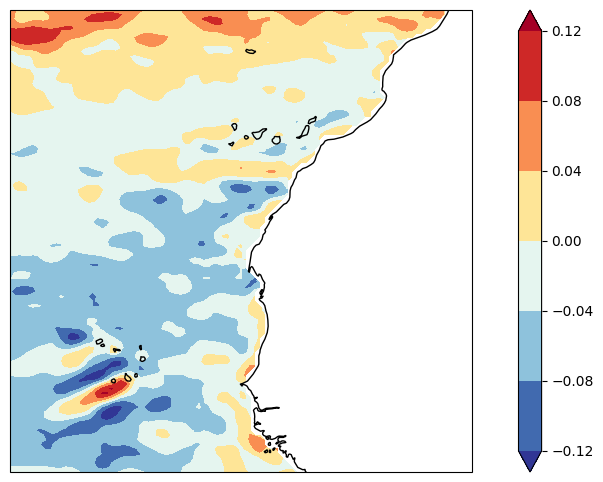

In [9]:
ff=np.squeeze(u.values[0,:,:]).T
x=ds['longitude'].sel(longitude=slice(xmin,xmax)).values
y=ds['latitude'].sel(latitude=slice(ymin,ymax)).values
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(x, y, ff, cmap='RdYlBu_r', extend='both', transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)


Text(0, 0.5, 'Latitude')

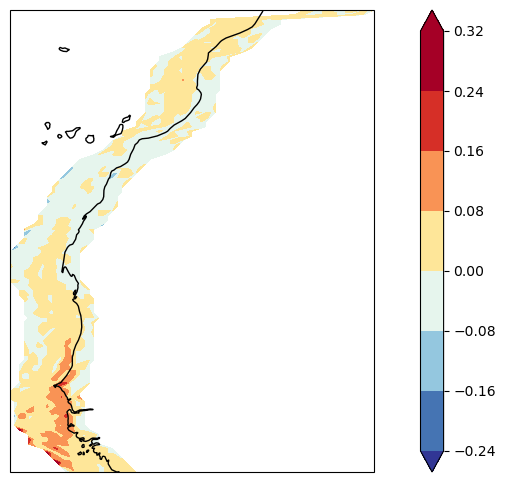

In [85]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ff = v[0, :, :]

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(
    lono, lato, ff, 
    cmap='RdYlBu_r', 
    extend='both', 
    vmin=-0.25, vmax=0.25,
    transform=ccrs.PlateCarree()
)
ax.coastlines()
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

In [ ]:
a=ds['latitude'].sel(latitude=slice(ymin, ymax)).data
b=lat.data
np.array_equal(a,b)

# model

## all vars

In [7]:
[xmin,xmax,ymin,ymax]=[330,355,10,35]
[tmin,tmax]=["1993","2022"]

# coast
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm
import glob


file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(
    file_path
)


lon=ds['lon'].sel(lon=slice(xmin, xmax)).values
lat=ds['lat'].sel(lat=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))
sst0=np.squeeze(ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0).values)

coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

# Paths to datasets
file_paths = [
    '/gxfs_home/geomar/smomw639/FESOM/analysis/fesom_core2_fjra_seasonal_d_1993_2022.nc',
    '/gxfs_home/geomar/smomw639/FESOM/analysis/fesom_core2_fjra_seasonal_w_mld3_d_1993_2022.nc'
]

# Load both files into one Dataset (merging variables)
ds = xr.merge([xr.open_dataset(os.path.expandvars(fp)) for fp in file_paths])

# Normalize longitude (0..360) and sort
ds = ds.assign_coords(lon=((ds['lon'] + 360) % 360)).sortby('lon')
ds = ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
    
# Select all variables in the combined dataset
processed_vars = {var: ds[var] for var in ds.data_vars}

# Setup arrays
ntime = next(iter(processed_vars.values())).shape[0]
n = 16  # coast band + ocean band
npoints = len(coast['lat'])

# Allocate memory
data_out = {key: np.empty((ntime, npoints, n)) for key in processed_vars}
lono = np.empty((npoints, n))
lato = np.empty((npoints, n))

# Loop through coastal points
for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()

    lon_slice_idx = slice(int(lon_idx - n), int(lon_idx))
    for key, da in processed_vars.items():
        data_out[key][:, point_idx, :] = da[:, lat_idx, lon_slice_idx]

    lono[point_idx, :] = lon[lon_slice_idx]
    lato[point_idx, :] = lat[lat_idx]

# Save everything
save_dict = {**data_out, 'lono': lono, 'lato': lato}
np.savez(f'fesom_core2_fjra_d_{tmin}_{tmax}.npz', **save_dict)


In [18]:
# w
[xmin,xmax,ymin,ymax]=[330,355,10,35]
[tmin,tmax]=["1993","2022"]

# coast
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm
import glob


file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(
    file_path
)


lon=ds['lon'].sel(lon=slice(xmin, xmax)).values
lat=ds['lat'].sel(lat=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))
sst0=np.squeeze(ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0).values)

coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

# Paths to datasets
file_paths = [
    '/gxfs_home/geomar/smomw639/FESOM/analysis/fesom_core2_fjra_seasonal_w_mld1_d_1993_2022.nc'
]

# Load both files into one Dataset (merging variables)
ds = xr.merge([xr.open_dataset(os.path.expandvars(fp)) for fp in file_paths])

# Normalize longitude (0..360) and sort
ds = ds.assign_coords(lon=((ds['lon'] + 360) % 360)).sortby('lon')
ds = ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
    
coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  


# Select all variables in the combined dataset
processed_vars = {var: ds[var] for var in ds.data_vars}

# Setup arrays
ntime = next(iter(processed_vars.values())).shape[0]
n = 16  # coast band + ocean band
npoints = len(coast['lat'])

# Allocate memory
data_out = {key: np.empty((ntime, npoints, n)) for key in processed_vars}
lono = np.empty((npoints, n))
lato = np.empty((npoints, n))

# Loop through coastal points
for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()

    lon_slice_idx = slice(int(lon_idx - n), int(lon_idx))
    for key, da in processed_vars.items():
        data_out[key][:, point_idx, :] = da[:, lat_idx, lon_slice_idx]

    lono[point_idx, :] = lon[lon_slice_idx]
    lato[point_idx, :] = lat[lat_idx]

# Save everything
save_dict = {**data_out, 'lono': lono, 'lato': lato}
np.savez(f'fesom_core2_fjra_w_mld1_d_{tmin}_{tmax}.npz', **save_dict)



## w estimate

In [15]:
# wind ekman transport and pumping
[xmin,xmax,ymin,ymax]=[330,355,10,35]
[tmin,tmax]=["1993","2022"]

# coast
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm
import glob


file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(
    file_path
)


lon=ds['lon'].sel(lon=slice(xmin, xmax)).values
lat=ds['lat'].sel(lat=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))
sst0=np.squeeze(ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0).values)

coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

# Paths to datasets
file_paths = [
    '/gxfs_home/geomar/smomw639/FESOM/analysis/fesom_core2_fjra_seasonal_d_1993_2022.nc',
]

# Load both files into one Dataset (merging variables)
ds = xr.merge([xr.open_dataset(os.path.expandvars(fp)) for fp in file_paths])

# Normalize longitude (0..360) and sort
ds = ds.assign_coords(lon=((ds['lon'] + 360) % 360)).sortby('lon')
ds = ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
    
coast = {'lat': [], 'lon': []}
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

n = 8
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))


u = ds['tx_sur'].values
v = ds['ty_sur'].values

uc = np.empty((u.shape[0],len(coast['lat']), n))
vc = np.empty((v.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = u[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = v[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
wind_alongshore = uc * u_alongshore + vc * v_alongshore

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, latc, lonc)  # Shape: (100, 8)

# Constants
rhoa = 1.22  # air density (kg/m^3)
cd = 0.0013  # drag coefficient
rho = 1025  # water density (kg/m^3)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

f = 2 * omega * np.sin(latc* np.pi / 180)

# Calculate magnitude of horizontal velocity
windspeed = np.sqrt(uc**2 + vc**2)

# Ekman transport calculation
etransport = -wind_alongshore / (rho * f * distances)
# wind_alongshore_mean = wind_alongshore[:, :, 0]
# mwind_alongshore_mean_filled = np.broadcast_to(wind_alongshore_mean[:, :, np.newaxis], wind_alongshore.shape)
# etransport = -wind_alongshore_mean_filled / (rho * f * distances)

epumping = np.zeros_like(uc)  # Ensure it has the right shape and is mutable
epumping_nobeta = np.zeros_like(uc)
dy = 111000.0 * (lat[1] - lat[0])  # scalar
dv_dx = np.zeros_like(uc)
for j in range(lat.shape[0]):
    x_j = 111000.0 * np.cos(np.radians(lat[j])) * (lon[1] - lon[0]) 
    epumping[:,j,:] = 1 / (rho*f[j]) * (np.gradient(vc[:, j, :], x_j, axis=-1) - np.gradient(uc[:,j,:], dy, axis=1))

np.savez(f'fesom_core2_fjra_ekman_d_{tmin}_{tmax}.npz', windspeed=windspeed, etransport=etransport, epumping=epumping)


In [16]:
# geostrophic currents
[xmin,xmax,ymin,ymax]=[330,355,10,35]
[tmin,tmax]=["1993","2022"]

# coast
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm
import glob


file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(
    file_path
)


lon=ds['lon'].sel(lon=slice(xmin, xmax)).values
lat=ds['lat'].sel(lat=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))
sst0=np.squeeze(ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0).values)

coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

# Paths to datasets
file_paths = [
    '/gxfs_home/geomar/smomw639/FESOM/analysis/fesom_core2_fjra_seasonal_d_1993_2022.nc',
]

# Load both files into one Dataset (merging variables)
ds = xr.merge([xr.open_dataset(os.path.expandvars(fp)) for fp in file_paths])

# Normalize longitude (0..360) and sort
ds = ds.assign_coords(lon=((ds['lon'] + 360) % 360)).sortby('lon')
ds = ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
    
coast = {'lat': [], 'lon': []}
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  

n = 8
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))


ssh = ds['ssh'].values
mld = ds['MLD1'].values
# ssh: (time, lat, lon); mld: (time, lat, lon)

g = 9.81
Omega = 7.292115e-5

lat_rad = np.deg2rad(lat)

# Coriolis f(lat) -> (1, Ny, 1)
f = (2 * Omega * np.sin(lat_rad))[None, :, None]

# Derivatives per degree using 1-D coord arrays (valid for np.gradient)
deta_dlat_deg = np.gradient(ssh, lat, axis=1)   # (T, Ny, Nx)
deta_dlon_deg = np.gradient(ssh, lon, axis=2)   # (T, Ny, Nx)

# Convert degrees -> meters
m_per_deg_lat = 111000.0
m_per_deg_lon = (111000.0 * np.cos(lat_rad))[None, :, None]  # (1, Ny, 1)

deta_dy = deta_dlat_deg / m_per_deg_lat
deta_dx = deta_dlon_deg / m_per_deg_lon

# Geostrophic velocities
ug = -g / f * deta_dy
vg =  g / f * deta_dx


n = 16  # coast band + ocean band
ugc = np.empty((ug.shape[0],len(coast['lat']), n))
vgc = np.empty((vg.shape[0],len(coast['lat']), n))
mldc = np.empty((ssh.shape[0],len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    ugc[:, point_idx, :] = ug[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vgc[:, point_idx, :] = vg[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    mldc[:, point_idx, :] = mld[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, lato, lono)  # Shape: (100, 8)

ucsc = ugc * v_alongshore - vgc * u_alongshore
wgc = ucsc /distances * (mldc)
np.savez(f'fesom_core2_fjra_wg_mld1_d_{tmin}_{tmax}.npz', wgc=wgc)


Text(0, 0.5, 'Latitude')

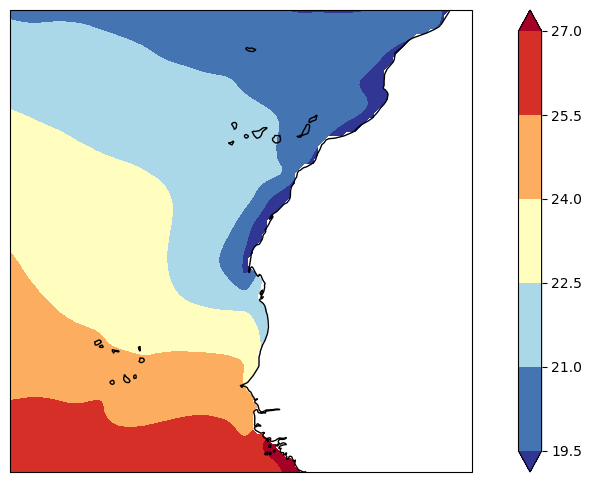

In [17]:
file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(
    file_path
)
ds['lon'] = (ds['lon'] + 360) % 360
ds=ds.sortby('lon').sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))

sst=ds['sst'].values
lon=ds['lon'].values
lat=ds['lat'].values

ff = sst.mean(axis=0)

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(
    lon, lat, ff, 
    cmap='RdYlBu_r', 
    extend='both', 
    transform=ccrs.PlateCarree()
)
ax.coastlines()
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

In [23]:
# ca
[xmin,xmax,ymin,ymax]= [330,355,10,35]#[5,20,-34,-20]#[230,244,32,46] #[270,290,-16,-6]
[tmin,tmax]=["1993","2022"]

# coast
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm
import glob


file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(
    file_path
)


lon=ds['lon'].sel(lon=slice(xmin, xmax)).values
lat=ds['lat'].sel(lat=slice(ymin,ymax)).values
time=ds['time'].sel(time=slice(tmin,tmax))



sst0=np.squeeze(ds['sst'].sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax)).isel(time=0).values)


    
coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  



In [24]:
# wind ekman transport and pumping

# coast
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from matplotlib import cm
import glob


# Paths to datasets
file_paths = [
    '/gxfs_home/geomar/smomw639/FESOM/analysis/fesom_core2_fjra_seasonal_d_1993_2022.nc',
]

# Load both files into one Dataset (merging variables)
ds = xr.merge([xr.open_dataset(os.path.expandvars(fp)) for fp in file_paths])

# Normalize longitude (0..360) and sort
ds = ds.assign_coords(lon=((ds['lon'] + 360) % 360)).sortby('lon')
ds = ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
    
n = 8
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))


u = ds['tx_sur'].values
v = ds['ty_sur'].values

uc = np.empty((u.shape[0],len(coast['lat']), n))
vc = np.empty((v.shape[0],len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    uc[:, point_idx, :] = u[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vc[:, point_idx, :] = v[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lonc[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    latc[point_idx, :] = lat[lat_idx]

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)
wind_alongshore = uc * u_alongshore + vc * v_alongshore

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, latc, lonc)  # Shape: (100, 8)

# Constants
rhoa = 1.22  # air density (kg/m^3)
cd = 0.0013  # drag coefficient
rho = 1025  # water density (kg/m^3)
omega = 7.2921e-5  # Earth's rotation rate (rad/s)

f = 2 * omega * np.sin(latc* np.pi / 180)

# Calculate magnitude of horizontal velocity
windspeed = np.sqrt(uc**2 + vc**2)

# Ekman transport calculation
etransport = -wind_alongshore / (rho * f * distances)
# wind_alongshore_mean = wind_alongshore[:, :, 0]
# mwind_alongshore_mean_filled = np.broadcast_to(wind_alongshore_mean[:, :, np.newaxis], wind_alongshore.shape)
# etransport = -wind_alongshore_mean_filled / (rho * f * distances)

epumping = np.zeros_like(uc)  # Ensure it has the right shape and is mutable
epumping_nobeta = np.zeros_like(uc)
dy = 111000.0 * (lat[1] - lat[0])  # scalar
dv_dx = np.zeros_like(uc)
for j in range(lat.shape[0]):
    x_j = 111000.0 * np.cos(np.radians(lat[j])) * (lon[1] - lon[0]) 
    epumping[:,j,:] = 1 / (rho*f[j]) * (np.gradient(vc[:, j, :], x_j, axis=-1) - np.gradient(uc[:,j,:], dy, axis=1))

np.savez(f'fesom_core2_fjra_ekman_d_{tmin}_{tmax}.npz', windspeed=windspeed, etransport=etransport, epumping=epumping)


In [25]:
# geostrophic currents

# Paths to datasets
file_paths = [
    '/gxfs_home/geomar/smomw639/FESOM/analysis/fesom_core2_fjra_seasonal_d_1993_2022.nc',
]

# Load both files into one Dataset (merging variables)
ds = xr.merge([xr.open_dataset(os.path.expandvars(fp)) for fp in file_paths])

# Normalize longitude (0..360) and sort
ds = ds.assign_coords(lon=((ds['lon'] + 360) % 360)).sortby('lon')
ds = ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))

n = 8
lonc = np.empty((len(coast['lat']), n))
latc = np.empty((len(coast['lat']), n))


ssh = ds['ssh'].values
mld = ds['MLD1'].values
# ssh: (time, lat, lon); mld: (time, lat, lon)

g = 9.81
Omega = 7.292115e-5

lat_rad = np.deg2rad(lat)

# Coriolis f(lat) -> (1, Ny, 1)
f = (2 * Omega * np.sin(lat_rad))[None, :, None]

# Derivatives per degree using 1-D coord arrays (valid for np.gradient)
deta_dlat_deg = np.gradient(ssh, lat, axis=1)   # (T, Ny, Nx)
deta_dlon_deg = np.gradient(ssh, lon, axis=2)   # (T, Ny, Nx)

# Convert degrees -> meters
m_per_deg_lat = 111000.0
m_per_deg_lon = (111000.0 * np.cos(lat_rad))[None, :, None]  # (1, Ny, 1)

deta_dy = deta_dlat_deg / m_per_deg_lat
deta_dx = deta_dlon_deg / m_per_deg_lon

# Geostrophic velocities
ug = -g / f * deta_dy
vg =  g / f * deta_dx


n = 16  # coast band + ocean band
ugc = np.empty((ug.shape[0],len(coast['lat']), n))
vgc = np.empty((vg.shape[0],len(coast['lat']), n))
mldc = np.empty((ssh.shape[0],len(coast['lat']), n))

lono = np.empty((len(coast['lat']), n))
lato = np.empty((len(coast['lat']), n))

for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()
    ugc[:, point_idx, :] = ug[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    vgc[:, point_idx, :] = vg[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    mldc[:, point_idx, :] = mld[:, lat_idx, int(lon_idx-n) : int(lon_idx)]
    lono[point_idx, :] = lon[int(lon_idx-n) : int(lon_idx)]
    lato[point_idx, :] = lat[lat_idx]

# alongshore wind
def calculate_bearing(lat1, lon1, lat2, lon2):
    lat1_rad = np.deg2rad(lat1)
    lat2_rad = np.deg2rad(lat2)
    lon1_rad = np.deg2rad(lon1)
    lon2_rad = np.deg2rad(lon2)
    
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    x = delta_lon * np.cos((lat1_rad + lat2_rad) / 2)
    y = delta_lat
    
    bearing_rad = np.arctan2(y, x)
    bearing_deg = np.rad2deg(bearing_rad)
    bearing_deg = (bearing_deg + 360) % 360
    
    return bearing_deg

point_num = len(coast['lat'])
coast_orientation = np.empty(point_num)

for i in range(point_num):
    if i < point_num - 1:
        lat1 = coast['lat'][i]
        lon1 = coast['lon'][i]
        lat2 = coast['lat'][i+1]
        lon2 = coast['lon'][i+1]
    else:
        lat1 = coast['lat'][i-1]
        lon1 = coast['lon'][i-1]
        lat2 = coast['lat'][i]
        lon2 = coast['lon'][i]
    
    bearing = calculate_bearing(lat1, lon1, lat2, lon2)
    coast_orientation[i] = bearing

coast_orientation_rad = np.deg2rad(coast_orientation)
u_alongshore = np.cos(coast_orientation_rad).reshape(1, point_num, 1)
v_alongshore = np.sin(coast_orientation_rad).reshape(1, point_num, 1)

# Define the haversine function
coast_lon = np.array(coast['lon'])  # Shape: (100,)
coast_lat = np.array(coast['lat'])  # Shape: (100,)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  

    # Convert degrees to radians
    lat1_rad = np.deg2rad(lat1)
    lon1_rad = np.deg2rad(lon1)
    lat2_rad = np.deg2rad(lat2)
    lon2_rad = np.deg2rad(lon2)

    # Compute differences
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(delta_lat / 2.0) ** 2 + \
        np.cos(lat1_rad) * np.cos(lat2_rad) * \
        np.sin(delta_lon / 2.0) ** 2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

# Expand coast_lon and coast_lat for broadcasting
coast_lon_expanded = coast_lon[:, np.newaxis]  # Shape: (100, 1)
coast_lat_expanded = coast_lat[:, np.newaxis]  # Shape: (100, 1)

# Compute distances
distances = haversine(coast_lat_expanded, coast_lon_expanded, lato, lono)  # Shape: (100, 8)

ucsc = ugc * v_alongshore - vgc * u_alongshore
wgc = ucsc /distances * (mldc)
np.savez(f'fesom_core2_fjra_wg_mld1_d_{tmin}_{tmax}.npz', wgc=wgc)


In [26]:
# w

# Paths to datasets
file_paths = [
    '/gxfs_home/geomar/smomw639/FESOM/analysis/fesom_core2_fjra_seasonal_w_mld1_d_1993_2022.nc'
]

# Load both files into one Dataset (merging variables)
ds = xr.merge([xr.open_dataset(os.path.expandvars(fp)) for fp in file_paths])

# Normalize longitude (0..360) and sort
ds = ds.assign_coords(lon=((ds['lon'] + 360) % 360)).sortby('lon')
ds = ds.sel(lon=slice(xmin,xmax), lat=slice(ymin,ymax))
    
coast = {'lat': [], 'lon': []}
    
for i, lat_val in enumerate(lat):
    for j, lon_val in enumerate(lon):            
        if np.isnan(sst0[i, j]):
            coast['lat'].append(lat_val.item())
            coast['lon'].append(lon_val.item())
            break  


# Select all variables in the combined dataset
processed_vars = {var: ds[var] for var in ds.data_vars}

# Setup arrays
ntime = next(iter(processed_vars.values())).shape[0]
n = 16  # coast band + ocean band
npoints = len(coast['lat'])

# Allocate memory
data_out = {key: np.empty((ntime, npoints, n)) for key in processed_vars}
lono = np.empty((npoints, n))
lato = np.empty((npoints, n))

# Loop through coastal points
for point_idx, (lat_val, lon_val) in enumerate(zip(coast['lat'], coast['lon'])):
    lat_idx = np.abs(lat - lat_val).argmin()
    lon_idx = np.abs(lon - lon_val).argmin()

    lon_slice_idx = slice(int(lon_idx - n), int(lon_idx))
    for key, da in processed_vars.items():
        data_out[key][:, point_idx, :] = da[:, lat_idx, lon_slice_idx]

    lono[point_idx, :] = lon[lon_slice_idx]
    lato[point_idx, :] = lat[lat_idx]

# Save everything
save_dict = {**data_out, 'lono': lono, 'lato': lato}
np.savez(f'fesom_core2_fjra_w_mld1_d_{tmin}_{tmax}.npz', **save_dict)



In [ ]:

ds

<xarray.Dataset> Size: 18GB
Dimensions:    (time: 366, lat: 720, lon: 1440)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-31
  * lat        (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon        (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    sst        (time, lat, lon) float32 2GB ...
    sss        (time, lat, lon) float32 2GB ...
    MLD1       (time, lat, lon) float32 2GB ...
    MLD2       (time, lat, lon) float32 2GB ...
    MLD3       (time, lat, lon) float32 2GB ...
    fh         (time, lat, lon) float32 2GB ...
    tx_sur     (time, lat, lon) float64 3GB ...
    ty_sur     (time, lat, lon) float64 3GB ...
    curl_surf  (time, lat, lon) float32 2GB ...
    ssh        (time, lat, lon) float32 2GB ...